In [1]:
import scipy.io
import os
import tensorflow as tf
import model

2024-04-16 01:36:09.563133: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 01:36:09.563180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 01:36:09.564397: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-16 01:36:09.573355: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 01:36:13.623867: W tensorflow/compiler/tf2

In [2]:
working_dir = os.getcwd()

file_path = os.path.join(working_dir, 'jaxpi', 'examples', 'allen_cahn','data', 'allen_cahn.mat')

data = scipy.io.loadmat(file_path)

# get data for model
x = data['x'].flatten()
t = data['t'].flatten()
usol = data['usol']

In [3]:
pinn = model.ConventionalAllenCahnPINN(t,x,usol)

Shape of Data
t: (201,)
x: (512,)
usol: (201, 512)


2024-04-16 01:36:18.309224: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-16 01:36:18.445309: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-16 01:36:18.445358: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-16 01:36:18.447186: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-16 01:36:18.447249: I external/local_xla/xla/stream_executor

t_initial: (512,)
x_initial: (512,)
usol_initial: (512,)
x_train: (102912,)
t_train: (102912,)
usol_train: (102912,)
x_negative_bound: (201,)
x_positive_bound: (201,)
t_bc: (201,)


In [4]:
pinn.train(10000)

Epoch 1
Calculating Loss Value


2024-04-16 01:36:19.263180: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Updating Weights


2024-04-16 01:36:20.051499: I external/local_xla/xla/service/service.cc:168] XLA service 0x55c0a5026780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-16 01:36:20.051547: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-04-16 01:36:20.056327: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-16 01:36:20.073571: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1713256580.148819  255926 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 2
Calculating Loss Value
Updating Weights
Epoch 3
Calculating Loss Value
Updating Weights
Epoch 4
Calculating Loss Value
Updating Weights
Epoch 5
Calculating Loss Value
Updating Weights
Epoch 6
Calculating Loss Value
Updating Weights
Epoch 7
Calculating Loss Value
Updating Weights
Epoch 8
Calculating Loss Value
Updating Weights
Epoch 9
Calculating Loss Value
Updating Weights
Epoch 10
Calculating Loss Value
Updating Weights
Epoch 11
Calculating Loss Value
Updating Weights
Epoch 12
Calculating Loss Value
Updating Weights
Epoch 13
Calculating Loss Value
Updating Weights
Epoch 14
Calculating Loss Value
Updating Weights
Epoch 15
Calculating Loss Value
Updating Weights
Epoch 16
Calculating Loss Value
Updating Weights
Epoch 17
Calculating Loss Value
Updating Weights
Epoch 18
Calculating Loss Value
Updating Weights
Epoch 19
Calculating Loss Value
Updating Weights
Epoch 20
Calculating Loss Value
Updating Weights
Epoch 21
Calculating Loss Value
Updating Weights
Epoch 22
Calculating Loss Va

In [5]:
total_losses = pinn.losses['total_loss']
print(total_losses)

[0.1645154505968094, 1.4674043655395508, 0.2491377592086792, 0.17963376641273499, 0.414223313331604, 0.39902782440185547, 0.22091877460479736, 0.07151862978935242, 0.04168466478586197, 0.11091235280036926, 0.17320826649665833, 0.160428985953331, 0.10200747847557068, 0.0508972629904747, 0.029671290889382362, 0.032315876334905624, 0.04448914900422096, 0.055601850152015686, 0.06025639921426773, 0.05635898932814598, 0.044941194355487823, 0.03062385320663452, 0.01955626718699932, 0.015646744519472122, 0.018409142270684242, 0.02395680546760559, 0.02801087498664856, 0.02845381200313568, 0.02565014734864235, 0.02104821428656578, 0.0159602127969265, 0.011445561423897743, 0.008515006862580776, 0.007768587674945593, 0.00883044209331274, 0.010442178696393967, 0.011290237307548523, 0.010805708356201649, 0.009256445802748203, 0.0072332932613790035, 0.005199519917368889, 0.003501215483993292, 0.002510534832254052, 0.0024425252340734005, 0.003035545814782381, 0.003636152483522892, 0.003704665228724479

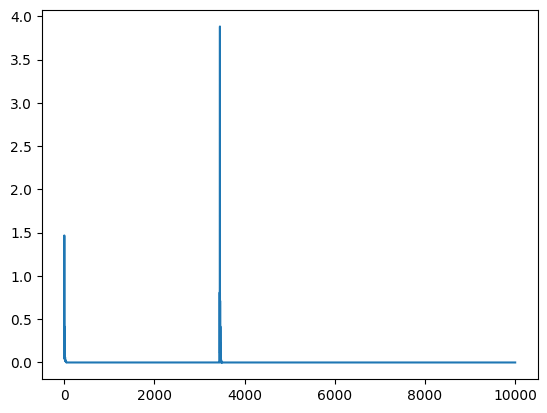

In [6]:
import matplotlib.pyplot as plt

x = [i+1 for i in range(len(total_losses))]

plt.plot(x, total_losses)

In [10]:
print(total_losses[-1])

0.0


In [8]:
result = pinn.evaluate()

print(result)

tf.Tensor(
[[-0.19796805 -0.19804464 -0.19812092 ... -0.19783881 -0.19777434
  -0.19770978]
 [-0.1947787  -0.1948541  -0.19492926 ... -0.19454055 -0.19447713
  -0.19441342]
 [-0.19158642 -0.19166064 -0.19173448 ... -0.19124086 -0.1911783
  -0.19111557]
 ...
 [ 0.4458305   0.44595167  0.4460723  ...  0.43603998  0.43587992
   0.43571937]
 [ 0.44890547  0.44902715  0.44914833 ...  0.43893287  0.43877172
   0.4386102 ]
 [ 0.45197654  0.45209876  0.45222038 ...  0.4418211   0.44165885
   0.44149637]], shape=(201, 512), dtype=float32)


In [9]:
diff = result-usol
print(diff)

tf.Tensor(
[[0.80203193 0.79406786 0.78598714 ... 0.7862692  0.79433817 0.8022902 ]
 [0.804586   0.7977315  0.78989786 ... 0.79028654 0.79810846 0.80495125]
 [0.807275   0.80132335 0.79379743 ... 0.7942911  0.8018057  0.8077459 ]
 ...
 [1.4458293  1.4459504  1.4460709  ... 1.4360385  1.4358786  1.4357182 ]
 [1.4489043  1.449026   1.449147   ... 1.4389315  1.4387705  1.438609  ]
 [1.4519753  1.4520977  1.452219   ... 1.4418198  1.4416578  1.4414952 ]], shape=(201, 512), dtype=float32)


In [11]:
pinn.model.save('ConventionalPinn')

INFO:tensorflow:Assets written to: ConventionalPinn/assets


INFO:tensorflow:Assets written to: ConventionalPinn/assets
